c:\Users\quant\miniconda3\envs\cenv4py310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best parameters: {'model__reg_value': 0.001, 'model__reg_type': 'l2', 'model__momentum': 0.97, 'model__layer3_neurons': 16, 'model__layer2_neurons': 64, 'epochs': 100, 'batch_size': 128}
Best Accuracy: 78.16%


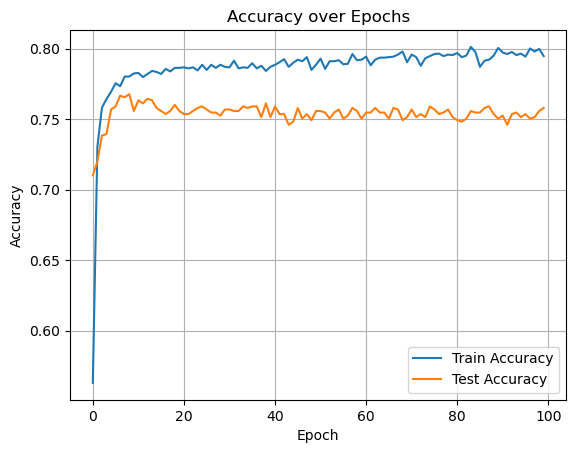

['models/nn_scaler.pkl']

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras import Input

#Read in Data from Updated CSV
df = pd.read_csv('student_dropout.csv')
X_nonscaled = df.drop('Target', axis=1)
y = df['Target'].astype(int)

#Standardize the Input Features
scaler = StandardScaler()
X = scaler.fit_transform(X_nonscaled)

#Split the training and test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Defining Function to Get Regularizer Objects
def get_regularizers(type, value):
    if type == 'l1':
        return regularizers.l1(value)
    elif type == 'l2':
        return regularizers.l2(value)
    else: return None

#Create the model with the appropiate hyperparameters minus batch_size which will dealt with by GridSearchCV
def create_model(momentum=0.9, reg_type=None, reg_value=0.01, layer2_neurons = 16, layer3_neurons = 16):
    reg = get_regularizers(reg_type, reg_value)

    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))
    model.add(Dense(layer2_neurons, activation='relu', kernel_regularizer=reg))
    model.add(Dense(layer3_neurons, activation='relu', kernel_regularizer=reg))
    model.add(Dense(3, activation='softmax')) 
    
    optimizer = SGD(momentum=momentum)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


model = KerasClassifier(
    model=create_model, 
    verbose = 0, 
    loss="categorical_crossentropy",
    layer2_neurons = 16,
    layer3_neurons = 16    
)

# Hyperparameter Search Grid
param_grid = {
    "model__momentum": [0.9, 0.95, 0.97],
    "model__reg_type": [None, "l1", "l2"],
    "model__reg_value": [0.001, 0.01],
    "model__layer2_neurons" : [16, 32, 64],
    "model__layer3_neurons" : [16, 32, 64],
    "batch_size": [16, 64, 128],
    "epochs": [100]

}

# Grid Search for Best Set of paramaters
grid = RandomizedSearchCV(
    estimator = model, 
    param_distributions = param_grid,
    n_iter= 50,
    cv=3, 
    n_jobs=-1, 
    scoring='accuracy',
    random_state=42
)

#Get the Search Results
grid_result = grid.fit(X_train, y_train)

# Printing the Best Paramaters and Accuracy
print("Best parameters:", grid_result.best_params_)
print("Best Accuracy: {:.2f}%".format(grid_result.best_score_ * 100))

# Get the best parameters from grid_result
best_params = grid_result.best_params_
best_momentum = best_params['model__momentum']
best_reg_type = best_params['model__reg_type']
best_reg_value = best_params['model__reg_value']
best_layer2_neurons = best_params['model__layer2_neurons']
best_layer3_neurons = best_params['model__layer3_neurons']

best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']

# Getting the best model
best_model = create_model(
    momentum = best_momentum,
    reg_type = best_reg_type,
    reg_value = best_reg_value,
    layer2_neurons = best_layer2_neurons,
    layer3_neurons = best_layer3_neurons
)

#Converting y to One-Hot Encoding
y_train_cat = to_categorical(y_train, num_classes = 3)
y_test_cat = to_categorical(y_test, num_classes = 3)

#Training the Best Model
history = best_model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    batch_size= best_batch_size,
    epochs=best_epochs,
    verbose = 0
)

# Show the visualization of the hyperparameters and MSE
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Save model and scaler
best_model.save('models/neural_network_model.h5')
joblib.dump(scaler, 'models/nn_scaler.pkl')

